In [2]:
import os
import csv
import pandas as pd

from tqdm import tqdm
from collections import Counter

In [3]:
file_list = os.listdir('./Keystrokes/files/')
file_list.remove('readme.txt')
file_list.remove('metadata_participants.txt')
len(file_list)

168593

In [6]:
# preproc files
for file in tqdm(file_list):

    f = open('./Keystrokes/files/' + file, 'r', encoding='windows-1252')

    # read file
    content = f.read()
    f.close()

    # replace \n
    content = content.replace('\t\n\t', '\tnewline\t')
    content = content.replace('\t\t\t', '\ttab\t')

    # save file
    f = open('./Keystroke_prc/' + file, 'w', encoding='windows-1252')
    f.write(content)
    f.close()


100%|██████████| 168593/168593 [02:52<00:00, 974.68it/s]


In [7]:
key_counter = Counter()
failed_files = []
failed_due_to_nan = []
for file in tqdm(file_list):
    try: 
        df = pd.read_csv('./Keystroke_prc/' + file , sep='\t', encoding="windows-1252", quoting=csv.QUOTE_NONE)

        if df['KEYCODE'].isnull().values.any():
            failed_due_to_nan.append((file, df['KEYCODE'].isnull().sum(), len(df)))
            continue

        key_counter.update(df['KEYCODE'].tolist())
    except:
        failed_files.append(file)

100%|██████████| 168593/168593 [04:27<00:00, 630.85it/s]


In [9]:
print("Failed due to nan",  len(failed_due_to_nan))
print("Failed due to other", len(failed_files))

Failed due to nan 0
Failed due to other 0


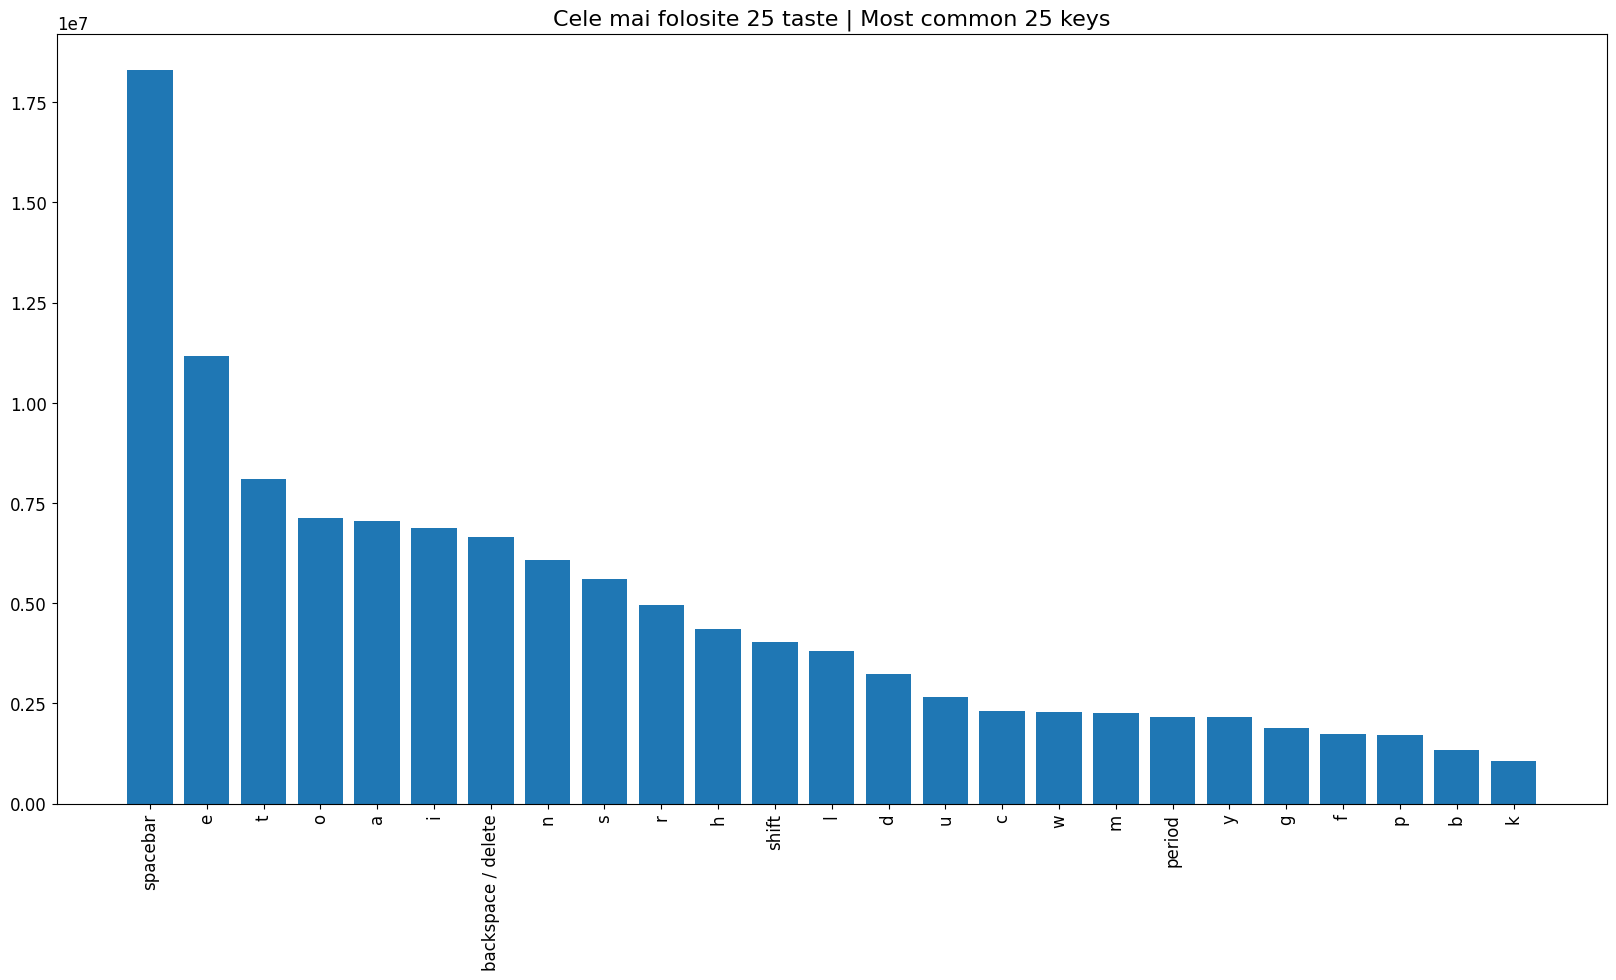

In [31]:
from key_codes_js import key_codes_js

sorted_keys =  key_counter.most_common(25)

# transform keycode to key
for i in range(len(sorted_keys)):
    sorted_keys[i] = (key_codes_js[sorted_keys[i][0]], sorted_keys[i][1])

sorted_keys

# plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

keys = [x[0] for x in sorted_keys]
values = [x[1] for x in sorted_keys]

plt.figure(figsize=(20,10))
plt.bar(keys, values)
plt.title('Cele mai folosite 25 taste | Most common 25 keys', fontsize=16)
plt.xticks(rotation=90)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12) 
plt.show()

In [33]:
df.head()

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE
0,426279,4594212,And I can't turn my phone on.,And I can't turn my phonw on.,218173900,1477859450648,1477859451144,SHIFT,16
1,426279,4594212,And I can't turn my phone on.,And I can't turn my phonw on.,218173893,1477859450880,1477859451072,A,65
2,426279,4594212,And I can't turn my phone on.,And I can't turn my phonw on.,218173908,1477859451088,1477859451200,N,78
3,426279,4594212,And I can't turn my phone on.,And I can't turn my phonw on.,218173914,1477859451240,1477859451384,d,68
4,426279,4594212,And I can't turn my phone on.,And I can't turn my phonw on.,218173923,1477859451408,1477859451528,,32


In [36]:
# Transform to sequence dataset
# Path: 136M_eda.ipynb
grp_df = df.groupby(['PARTICIPANT_ID', 'TEST_SECTION_ID'])

# iterate over each group
for name, seq_group in grp_df:
    print("Participant ID: ", name[0])
    print("Test Section ID: ", name[1])
    # iterate through seq_group
    sequence = []
    press_code = 1
    release_code = 0
    for index, row in seq_group.iterrows():
        press_time = row['PRESS_TIME']
        release_time = row['RELEASE_TIME']
        keycode = row['KEYCODE']
        sequence.append([press_time, press_code, keycode])
        sequence.append([release_time, release_code, keycode])

    # sort sequence by timea
    sequence.sort(key=lambda x: x[0])

    sequence_count = len(sequence)
    time_diff = sequence[sequence_count - 1][0] - sequence[0][0]

    print("Sequence count: ", sequence_count)
    print("Time diff: ", time_diff / 1000)
    print(sequence)

    # get typing features
    # typing_features = session_to_features(sequence)

    break



Participant ID:  426279
Test Section ID:  4594212
Sequence count:  78
Time diff:  14.807
[[1477859450648, 1, 16], [1477859450880, 1, 65], [1477859451072, 0, 65], [1477859451088, 1, 78], [1477859451144, 0, 16], [1477859451200, 0, 78], [1477859451240, 1, 68], [1477859451384, 0, 68], [1477859451408, 1, 32], [1477859451528, 0, 32], [1477859452056, 1, 8], [1477859452152, 0, 8], [1477859452232, 1, 8], [1477859452336, 0, 8], [1477859452640, 1, 8], [1477859452696, 0, 8], [1477859452968, 1, 78], [1477859453104, 0, 78], [1477859453105, 1, 68], [1477859453256, 0, 68], [1477859453256, 1, 32], [1477859453368, 0, 32], [1477859453520, 1, 16], [1477859454312, 1, 73], [1477859454400, 0, 73], [1477859454456, 0, 16], [1477859454552, 1, 32], [1477859454688, 0, 32], [1477859454720, 1, 67], [1477859454855, 0, 67], [1477859454912, 1, 65], [1477859455040, 0, 65], [1477859455168, 1, 78], [1477859455304, 0, 78], [1477859455488, 1, 84], [1477859455591, 0, 84], [1477859456791, 1, 8], [1477859456840, 0, 8], [14778

#### Ways to improve
Use a different feature selection/feature engineering method.


Current metric treats the pressings as bigrams. Why not tri-grams or n-grams?